## VAE Implementation for Image Generation
# VAE for MNIST

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

Step 1: Define the VAE Model

In [4]:


class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        
        # Encoder
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, latent_dim)  # Mean
        self.fc22 = nn.Linear(400, latent_dim)  # Log variance
        
        # Decoder
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 784)
        
    def encode(self, x):
        h1 = torch.relu(self.fc1(x.view(-1, 784)))
        return self.fc21(h1), self.fc22(h1)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


Step 2: Define the Loss Function (ELBO)

In [5]:
def loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # KL divergence
    KL_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KL_div


Step 3: Load MNIST Dataset

In [6]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|██████████| 9912422/9912422 [00:02<00:00, 4631104.32it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|██████████| 28881/28881 [00:00<00:00, 2625280.52it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|██████████| 1648877/1648877 [00:00<00:00, 3614239.89it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|██████████| 4542/4542 [00:00<00:00, 11921482.33it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Step 4: Train the Model

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

latent_dim = 20
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 100

train_losses = []
KL_divergence = []
reconstruction_loss = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    kl_div = 0
    recon_loss = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)

        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)

        loss = loss_function(recon_batch, data, mu, logvar)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        kl_div += torch.sum(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())).item()
        recon_loss += nn.functional.binary_cross_entropy(recon_batch, data.view(-1, 784), reduction='sum').item()

    train_losses.append(train_loss / len(train_loader.dataset))
    KL_divergence.append(kl_div / len(train_loader.dataset))
    reconstruction_loss.append(recon_loss / len(train_loader.dataset))

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss/len(train_loader.dataset):.4f}, '
          f'KL Div: {kl_div/len(train_loader.dataset):.4f}, Recon Loss: {recon_loss/len(train_loader.dataset):.4f}')


Epoch [1/100], Loss: 163.9946, KL Div: 15.5505, Recon Loss: 148.4442
Epoch [2/100], Loss: 120.9635, KL Div: 22.5784, Recon Loss: 98.3851
Epoch [3/100], Loss: 114.1718, KL Div: 24.1509, Recon Loss: 90.0208
Epoch [4/100], Loss: 111.3396, KL Div: 24.7115, Recon Loss: 86.6281
Epoch [5/100], Loss: 109.6802, KL Div: 24.9575, Recon Loss: 84.7227
Epoch [6/100], Loss: 108.5224, KL Div: 25.0930, Recon Loss: 83.4294
Epoch [7/100], Loss: 107.7225, KL Div: 25.2184, Recon Loss: 82.5041
Epoch [8/100], Loss: 107.1180, KL Div: 25.2913, Recon Loss: 81.8267
Epoch [9/100], Loss: 106.5918, KL Div: 25.3637, Recon Loss: 81.2281
Epoch [10/100], Loss: 106.2098, KL Div: 25.3945, Recon Loss: 80.8153
Epoch [11/100], Loss: 105.8076, KL Div: 25.4106, Recon Loss: 80.3971
Epoch [12/100], Loss: 105.5868, KL Div: 25.4866, Recon Loss: 80.1001
Epoch [13/100], Loss: 105.3105, KL Div: 25.4932, Recon Loss: 79.8174
Epoch [14/100], Loss: 105.0802, KL Div: 25.5179, Recon Loss: 79.5623
Epoch [15/100], Loss: 104.8453, KL Div: 25

Step 5: Visualize Reconstruction and Generated Images

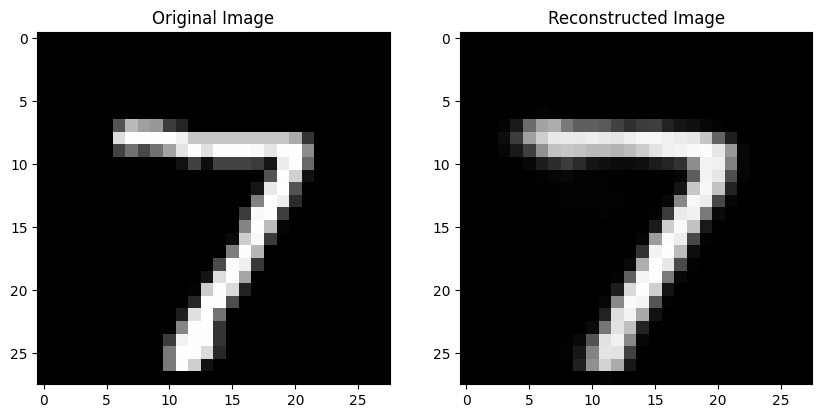

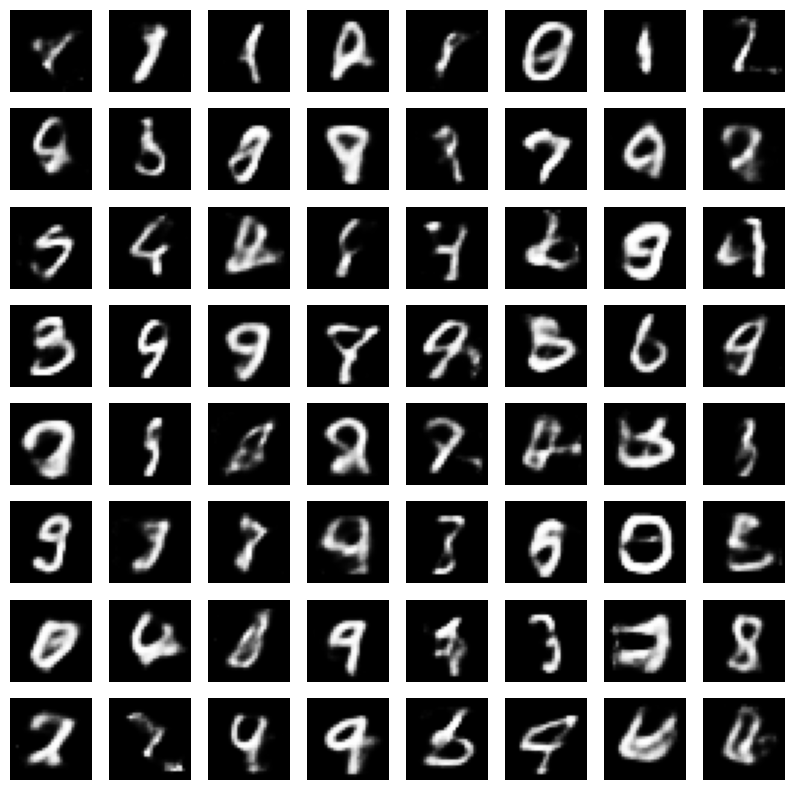

In [9]:
# Reconstruct and generate images
model.eval()

# Take some random test samples for reconstruction
with torch.no_grad():
    sample_data, _ = next(iter(test_loader))
    sample_data = sample_data.to(device)

    # Generate reconstructed images
    recon_images = model(sample_data)[0].view(-1, 1, 28, 28).cpu()

    # Plot original and reconstructed images
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(sample_data[0].view(28, 28).cpu().numpy(), cmap='gray')
    axes[0].set_title('Original Image')
    axes[1].imshow(recon_images[0].view(28, 28).numpy(), cmap='gray')
    axes[1].set_title('Reconstructed Image')
    plt.show()

# Generate new images by sampling from the latent space
with torch.no_grad():
    z = torch.randn(64, latent_dim).to(device)  # Sampling from a standard normal distribution
    generated_images = model.decode(z).view(-1, 1, 28, 28).cpu()

    # Plot the generated images
    fig, axes = plt.subplots(8, 8, figsize=(10, 10))
    for i in range(8):
        for j in range(8):
            axes[i, j].imshow(generated_images[i * 8 + j].view(28, 28).numpy(), cmap='gray')
            axes[i, j].axis('off')
    plt.show()


Step 6: Plot ELBO Loss and KL Divergence

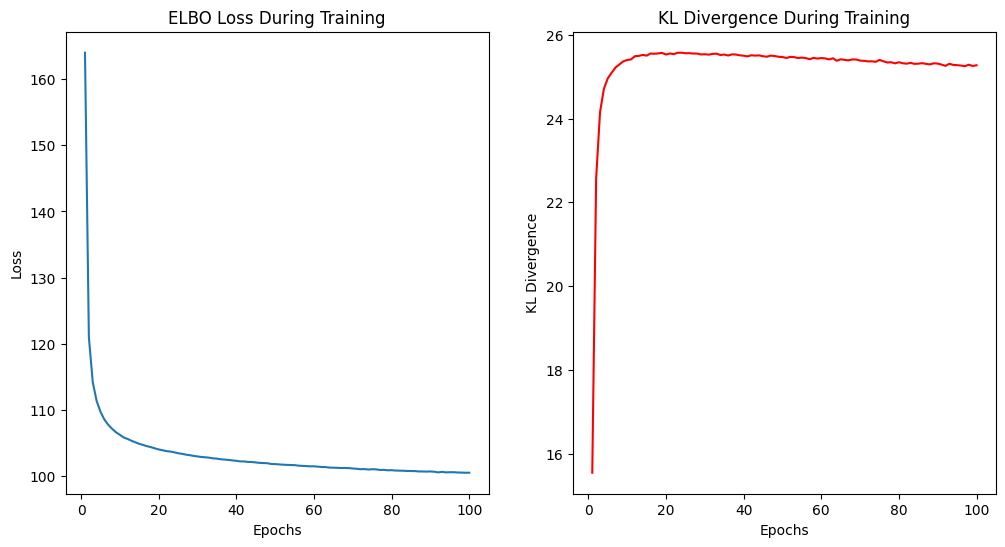

In [10]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="ELBO loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ELBO Loss During Training')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), KL_divergence, label="KL Divergence", color='r')
plt.xlabel('Epochs')
plt.ylabel('KL Divergence')
plt.title('KL Divergence During Training')

plt.show()
